In [2]:
#mount google drive in colab, comment out if in a local env
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
cd "gdrive/My Drive/NameFeaturesClassifier/NameFeaturesDetector"

/content/gdrive/My Drive/NameFeaturesClassifier/NameFeaturesDetector


In [4]:
import pandas as pd
import numpy as np
import pickle

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Model, save_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Dense
from tensorflow.keras.layers import Input, Embedding, Concatenate, Flatten
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

### Prepare the data to be inputted in the character level inception network like model.


In [5]:
#importing the data of names and names features 
with open("ressources/names.txt","r") as f:
  names = f.readlines()
  names = [name.replace('\n',"") for name in names]

features = np.load("ressources/features.npy",allow_pickle=True)

print(dict(zip(names[2:5],features[2:5])))

{'aage': ['danish', 'Male', 'Firstname'], 'aaliyah': ['dutch', 'english', 'Female', 'Firstname'], 'aalto': ['finnish', 'Last', 'Lastname']}


In [6]:
#splitting data into a train set and a test(dev) set
names_train, names_test, features_train, features_test = train_test_split(names,features,random_state = 50, test_size=0.1,)

In [7]:
#fitting a tokenizer on the train set of names, the tokenizer then has a vocabulary and useful methods to vectorize the training data
tk = Tokenizer(num_words=None, char_level=True, oov_token='<UNK>')
tk.fit_on_texts(names_train) #fitting on the training set only

#transforming names into sequences of ints, and padding the lists with 0s (PAD) so that they have the same length
#the length of inputs has been chosen so that 99% of the names are shorter than this length
inputLen = 12
sequences_train = tk.texts_to_sequences(names_train)
sequences_test = tk.texts_to_sequences(names_test)
sequences_train = pad_sequences(sequences=sequences_train, maxlen=inputLen, padding='post')
sequences_test = pad_sequences(sequences=sequences_test, maxlen=inputLen, padding='post')

In [8]:
#we consider the problem as a multi-label prediction problem, the model has to detect a certain number of features in names
#the outputs are vectorized in a binary vector indicating if a name has a feature or not
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(features_train)
y_test = mlb.fit_transform(features_test)

### Design and train an inception like network to extract features from person names 
The logic we used to design the model is the following.  
We removed languages for which the locality was almost always perfectly inferred by their alphabet. This reduced the vocabulary size.  
For languages using a latin alphabet we will try to uncover character ngrams   features (such as "eau" in french, or "vyk" in polish) which are discriminative features of some name locality.  
We use an [inception network](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43022.pdf) to uncover different size of character patterns in the first layer.  Some ngram features might be composed of smaller ngrams so that we can use more than one convolution layer to compose features and have less parameters in the first layer. Finally the features are flattened and passed to a Dense layer series with added regularization via Dropout.
Another idea was to use a RNN which looks for sequential features, and would not suffer from vanishing gradient because the sequence is rather short.
We could also combine models, and a next step is to try simpler models for this problem.  
Note here that as opposed with a Computer Vision classification model, the model does not have to be really deep because names are only 12 letters long, so we do not need to compose features through many layers.  
Also as opposed to CV, low level features between different classes are not really reusable...
Note that as the input is a sequence of one-hot vectors one filter in the first layer can be used to detect several features.  
We used the layer <code>Embedding</code> from <code>Keras</code> to speed up computations.  
A next step is also to review the way the model is evaluated, because the model seems to perform well when using it but the accuracy is quite low. The irreducible error might be quite large as well, but maybe another performance measure is more appropriate.

In [9]:
#model hyper-parameters
numClasses = len(mlb.classes_)
vocabSize = len(tk.word_index)
embeddingSize = vocabSize

optimizer="adam"
loss="binary_crossentropy"
batchSize = 128
metrics=["accuracy"]  #there might be a better evaluation metrics for the problem

dropoutRate = 0.3

callback = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)

In [10]:
#defining the model

#input layer
inputs = Input(shape=inputLen)

#embedding layer. With this layer we can directly input sequences of ints into the model, and this efficiently transforms
#these sequences into sequences of one hot vectors.
#would have used OneHotEncoder here, but apparently you need to have a vector of zeros for the PAD character in Keras
embeddingWeights = np.vstack((np.zeros(vocabSize),np.eye(vocabSize)))
embedding = Embedding(input_dim=vocabSize+1,output_dim=embeddingSize,
                input_length=inputLen,weights=[embeddingWeights])
embedding.trainable = False

#using a layer in the style of inception networks with different kernel size (looking for different elementary feature length)
L = embedding(inputs)
Conv1 = Conv1D(filters=32,kernel_size=1,padding="same",activation="relu")(L)
Conv2 = Conv1D(filters=32,kernel_size=2,padding="same",activation="relu")(L) 
Conv5 = Conv1D(filters=32,kernel_size=5,padding="same",activation="relu")(L)
L = Concatenate()([Conv1,Conv2,Conv5])

L = Conv1D(filters=128,kernel_size=3,padding="valid")(L)
L = Conv1D(filters=256,kernel_size=3,padding="valid")(L)

#reduce to one channel only
L = MaxPooling1D(pool_size=6)(L) 
L = Flatten()(L)

#dense part of the network regularized with Dropout
L = Dropout(rate = dropoutRate)(L)
L = Dense(units = 512,activation="relu")(L)
L = Dropout(rate = dropoutRate)(L)
L = Dense(units = 256,activation="relu")(L)

#multi-outputs layer
outputs = Dense(units= numClasses,activation="sigmoid")(L)

In [11]:
#define and compile the model
model = Model(inputs=inputs,outputs=outputs)
model.compile(optimizer=optimizer,loss=loss,metrics=metrics)

#model outputting representations of names used to define a similarity distance
representation = Model(inputs=inputs,outputs=L)

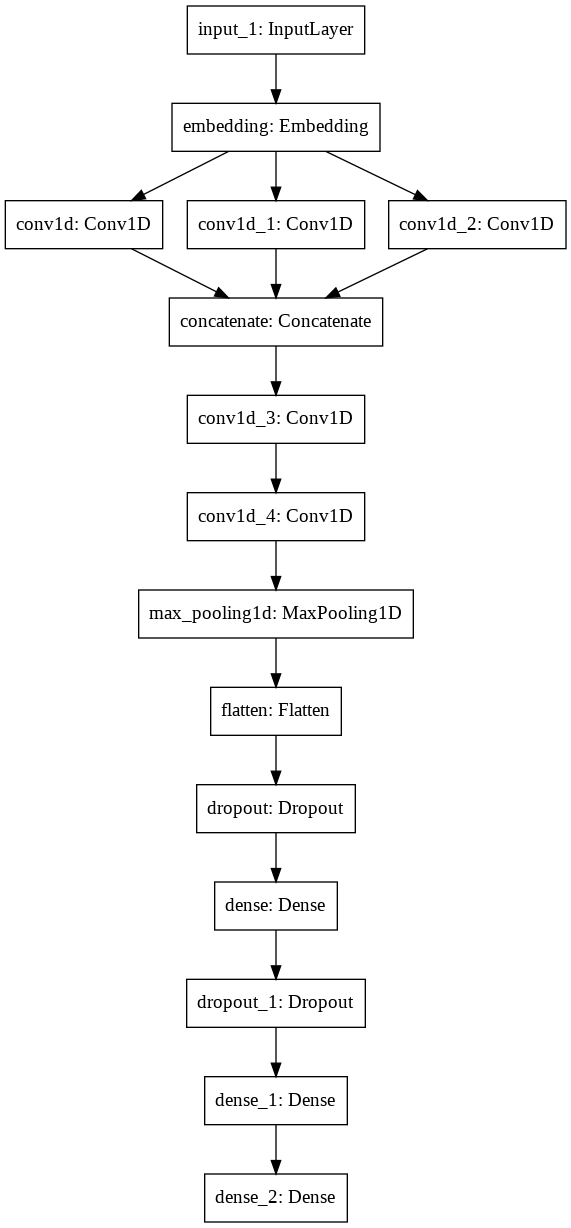

In [12]:
plot_model(model)

In [11]:
#fit the model using an early stopping callback, use GPU accelerator on colab for faster computations
model.fit(x=sequences_train,y=y_train,epochs=50,callbacks=[callback],
          validation_data=(sequences_test,y_test),batch_size=batchSize)

Epoch 1/50
159/159 [==============================] - 1s 6ms/step - loss: 0.2619 - accuracy: 0.2873 - val_loss: 0.2179 - val_accuracy: 0.4095
Epoch 2/50
159/159 [==============================] - 1s 5ms/step - loss: 0.2014 - accuracy: 0.3241 - val_loss: 0.1845 - val_accuracy: 0.3086
Epoch 3/50
159/159 [==============================] - 1s 5ms/step - loss: 0.1780 - accuracy: 0.3310 - val_loss: 0.1701 - val_accuracy: 0.2686
Epoch 4/50
159/159 [==============================] - 1s 5ms/step - loss: 0.1638 - accuracy: 0.3405 - val_loss: 0.1615 - val_accuracy: 0.3086
Epoch 5/50
159/159 [==============================] - 1s 5ms/step - loss: 0.1556 - accuracy: 0.3262 - val_loss: 0.1578 - val_accuracy: 0.4184
Epoch 6/50
159/159 [==============================] - 1s 4ms/step - loss: 0.1475 - accuracy: 0.3413 - val_loss: 0.1581 - val_accuracy: 0.3397
Epoch 7/50
159/159 [==============================] - 1s 5ms/step - loss: 0.1404 - accuracy: 0.3636 - val_loss: 0.1508 - val_accuracy: 0.4091
Epoch 

In [12]:
#evaluate model
round(accuracy_score(y_test,model.predict(sequences_test)>0.5),3)

0.431

In [13]:
#compute representations for names on the train and test set
repr_train = representation.predict(x=sequences_train)
repr_test = representation.predict(x=sequences_test)

#normalize for cosine similarity computations (to directly use np.dot())
repr_train = repr_train/np.linalg.norm(repr_train,axis=1).reshape(-1,1)
repr_test = repr_test/np.linalg.norm(repr_test,axis=1).reshape(-1,1)

In [14]:
#saving for later use
with open('ressources/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tk, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open("ressources/classes.txt","w") as f:
    for cl in mlb.classes_:
      f.write(cl+'\n')

np.save("ressources/repr_train.npy",repr_train)
np.save("ressources/repr_test.npy",repr_test)

save_model(model,"ressources/nameFeaturesDetector.h5")
save_model(representation,"ressources/nameRepresentation.h5")